In [117]:

import ast
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import plotly.express as px
import pandas as pd
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pickle
import scipy
from pandas import read_csv

In [118]:
store_df = read_csv('store.csv',low_memory=False)
train_df = pd.read_csv('train.csv', low_memory=False)

In [119]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [120]:

# STORE DATASET FILL INTO NULL VALUES I.E 0
store_df['CompetitionDistance'] = store_df['CompetitionDistance'].fillna(0)
store_df['CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(0)
store_df['CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(0)
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(0)
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(0)
store_df['PromoInterval'] = store_df['PromoInterval'].fillna(0)

In [121]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263.0,555.0,1.0,1.0,0,1.0
1,2,5,2015-07-31,6064.0,625.0,1.0,1.0,0,1.0
2,3,5,2015-07-31,8314.0,821.0,1.0,1.0,0,1.0
3,4,5,2015-07-31,13995.0,1498.0,1.0,1.0,0,1.0
4,5,5,2015-07-31,4822.0,559.0,1.0,1.0,0,1.0


In [122]:
merged_dff = pd.merge(store_df, train_df, on='Store', how='left')

In [123]:
merged_dff .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   StoreType                  1017209 non-null  object 
 2   Assortment                 1017209 non-null  object 
 3   CompetitionDistance        1017209 non-null  float64
 4   CompetitionOpenSinceMonth  1017209 non-null  float64
 5   CompetitionOpenSinceYear   1017209 non-null  float64
 6   Promo2                     1017209 non-null  int64  
 7   Promo2SinceWeek            1017209 non-null  float64
 8   Promo2SinceYear            1017209 non-null  float64
 9   PromoInterval              1017209 non-null  object 
 10  DayOfWeek                  1017209 non-null  int64  
 11  Date                       1017209 non-null  object 
 12  Sales                      1017209 non-null  int64  
 13  Customers   

In [124]:
# Attempt to parse the dates using the full format first
merged_dff['Date'] = pd.to_datetime(merged_dff['Date'], format='%Y-%m-%d', errors='coerce')

# For the entries that couldn't be parsed, try the partial format
merged_dff.loc[merged_dff['Date'].isna(), 'Date'] = pd.to_datetime(merged_dff.loc[merged_dff['Date'].isna(), 'Date'], format='%Y-%m', errors='coerce')

# Fill any remaining NaN values with a default date
merged_dff['Date'] = merged_dff['Date'].fillna(pd.to_datetime('2000-01-01'))

In [125]:
print(merged_dff['Date'].unique())

<DatetimeArray>
['2015-07-31 00:00:00', '2015-07-30 00:00:00', '2015-07-29 00:00:00',
 '2015-07-28 00:00:00', '2015-07-27 00:00:00', '2015-07-26 00:00:00',
 '2015-07-25 00:00:00', '2015-07-24 00:00:00', '2015-07-23 00:00:00',
 '2015-07-22 00:00:00',
 ...
 '2013-01-10 00:00:00', '2013-01-09 00:00:00', '2013-01-08 00:00:00',
 '2013-01-07 00:00:00', '2013-01-06 00:00:00', '2013-01-05 00:00:00',
 '2013-01-04 00:00:00', '2013-01-03 00:00:00', '2013-01-02 00:00:00',
 '2013-01-01 00:00:00']
Length: 942, dtype: datetime64[ns]


In [126]:
#Change data types object to int
merged_dff.loc[merged_dff['StateHoliday'] == '0', 'StateHoliday'] = 0
merged_dff.loc[merged_dff['StateHoliday'] == 'a', 'StateHoliday'] = 1
merged_dff.loc[merged_dff['StateHoliday'] == 'b', 'StateHoliday'] = 2
merged_dff.loc[merged_dff['StateHoliday'] == 'c', 'StateHoliday'] = 3

In [127]:
state_holiday_median = merged_dff['StateHoliday'].median()


# Fill the NaN values with the median
merged_dff['StateHoliday'] = merged_dff['StateHoliday'].fillna(state_holiday_median)
#store the value with same column name i.e StateHoliday with function astype
merged_dff['StateHoliday'] = merged_dff['StateHoliday'].astype(int, copy=False)

In [128]:

# code for change object into date format
merged_dff ['CompetitionOpenSinceMonth'] = pd.DatetimeIndex(merged_dff ['Date']).month

In [129]:

# code for change float into integer
merged_dff ['CompetitionOpenSinceYear']= merged_dff ['CompetitionOpenSinceYear'].astype(int)
merged_dff ['Promo2SinceYear']= merged_dff ['Promo2SinceYear'].astype(int)

In [130]:

# code for change float into integer
merged_dff['CompetitionDistance']= merged_dff['CompetitionDistance'].astype(int)
merged_dff['Promo2SinceWeek']= merged_dff['Promo2SinceWeek'].astype(int)

In [131]:
# change Data Types object into int
merged_dff.loc[merged_dff['Assortment'] == 'a', 'Assortment'] = 0
merged_dff.loc[merged_dff['Assortment'] == 'b', 'Assortment'] = 1
merged_dff.loc[merged_dff['Assortment'] == 'c', 'Assortment'] = 2

#store the value with same column name i.e Assortment with function astype
merged_dff['Assortment'] = merged_dff['Assortment'].astype(int, copy=False)

In [132]:
# Change Data Types object into int
merged_dff['StoreType'] = merged_dff['StoreType'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3})

# Convert the column to integer type
merged_dff['StoreType'] = merged_dff['StoreType'].astype(int, copy=False)

In [133]:
# Create a dictionary to map the string values to integer values
promo_interval_mapping = {
    'Jan,Apr,Jul,Oct': 1,
    'Feb,May,Aug,Nov': 2,
    'Mar,Jun,Sept,Dec': 3
}

# Fill the 'PromoInterval' column with the mapped integer values
merged_dff['PromoInterval'] = merged_dff['PromoInterval'].map(promo_interval_mapping).fillna(0)

In [134]:
merged_dff['PromoInterval'].unique()

array([0., 1., 2., 3.])

In [135]:
merged_dff

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,0,1270,7,2008,0,0,0,0.0,5,2015-07-31,5263,555,1,1,0,1
1,1,2,0,1270,7,2008,0,0,0,0.0,4,2015-07-30,5020,546,1,1,0,1
2,1,2,0,1270,7,2008,0,0,0,0.0,3,2015-07-29,4782,523,1,1,0,1
3,1,2,0,1270,7,2008,0,0,0,0.0,2,2015-07-28,5011,560,1,1,0,1
4,1,2,0,1270,7,2008,0,0,0,0.0,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,3,2,5350,1,0,1,22,2012,3.0,6,2013-01-05,4771,339,1,0,0,1
1017205,1115,3,2,5350,1,0,1,22,2012,3.0,5,2013-01-04,4540,326,1,0,0,1
1017206,1115,3,2,5350,1,0,1,22,2012,3.0,4,2013-01-03,4297,300,1,0,0,1
1017207,1115,3,2,5350,1,0,1,22,2012,3.0,3,2013-01-02,3697,305,1,0,0,1


In [71]:

merged_dff['Date']

0        2015-07-31
1        2015-07-30
2        2015-07-29
3        2015-07-28
4        2015-07-27
            ...    
980913   2013-02-07
980914   2013-02-06
980915   2013-02-05
980916   2013-02-04
980917   2013-02-03
Name: Date, Length: 980918, dtype: datetime64[ns]

In [76]:
merged_dff['Date'].unique()

<DatetimeArray>
['2015-07-31 00:00:00', '2015-07-30 00:00:00', '2015-07-29 00:00:00',
 '2015-07-28 00:00:00', '2015-07-27 00:00:00', '2015-07-26 00:00:00',
 '2015-07-25 00:00:00', '2015-07-24 00:00:00', '2015-07-23 00:00:00',
 '2015-07-22 00:00:00',
 ...
 '2013-02-10 00:00:00', '2013-02-09 00:00:00', '2013-02-08 00:00:00',
 '2013-02-07 00:00:00', '2013-02-06 00:00:00', '2013-02-05 00:00:00',
 '2013-02-04 00:00:00', '2013-02-03 00:00:00', '2013-02-02 00:00:00',
 '2000-01-01 00:00:00']
Length: 911, dtype: datetime64[ns]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,,,,,,,,,,
2015-07-31,1,2,0,1270,7,2008,0,0,0,0.0,5,5263,555,1,1,0,1
2015-07-30,1,2,0,1270,7,2008,0,0,0,0.0,4,5020,546,1,1,0,1
2015-07-29,1,2,0,1270,7,2008,0,0,0,0.0,3,4782,523,1,1,0,1
2015-07-28,1,2,0,1270,7,2008,0,0,0,0.0,2,5011,560,1,1,0,1
2015-07-27,1,2,0,1270,7,2008,0,0,0,0.0,1,6102,612,1,1,0,1


<Figure size 2000x1200 with 0 Axes>

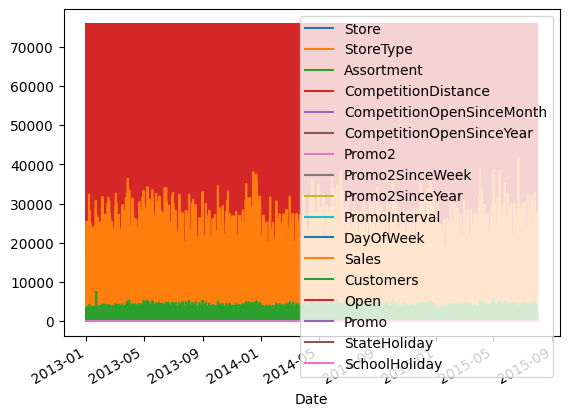

In [136]:
from pandas import read_csv
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt

def parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

df_series = merged_dff.copy()

# Set the Date column as the index
df_series = df_series.set_index('Date')

# Convert the index to datetime if it's not already
df_series.index = pd.to_datetime(df_series.index, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Drop rows with NaT in the index (if any)
df_series = df_series[df_series.index.notnull()]  # Change here

# Summarize first few rows
display(df_series.head())

# Line plot
plt.figure(figsize=(20, 12))
df_series.plot()
plt.show()

In [137]:
df_series.index

DatetimeIndex(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
               '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
               '2015-07-23', '2015-07-22',
               ...
               '2013-01-10', '2013-01-09', '2013-01-08', '2013-01-07',
               '2013-01-06', '2013-01-05', '2013-01-04', '2013-01-03',
               '2013-01-02', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [151]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


sales = df_series['Sales'].values

# Normalize the data
scaler = MinMaxScaler()
sales = scaler.fit_transform(sales.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(sales) * 0.8)  # Adjust split ratio as needed
train_data = sales[:train_size]
test_data = sales[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (adjust as needed)
sequence_length = 10

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

##  Visualize the split

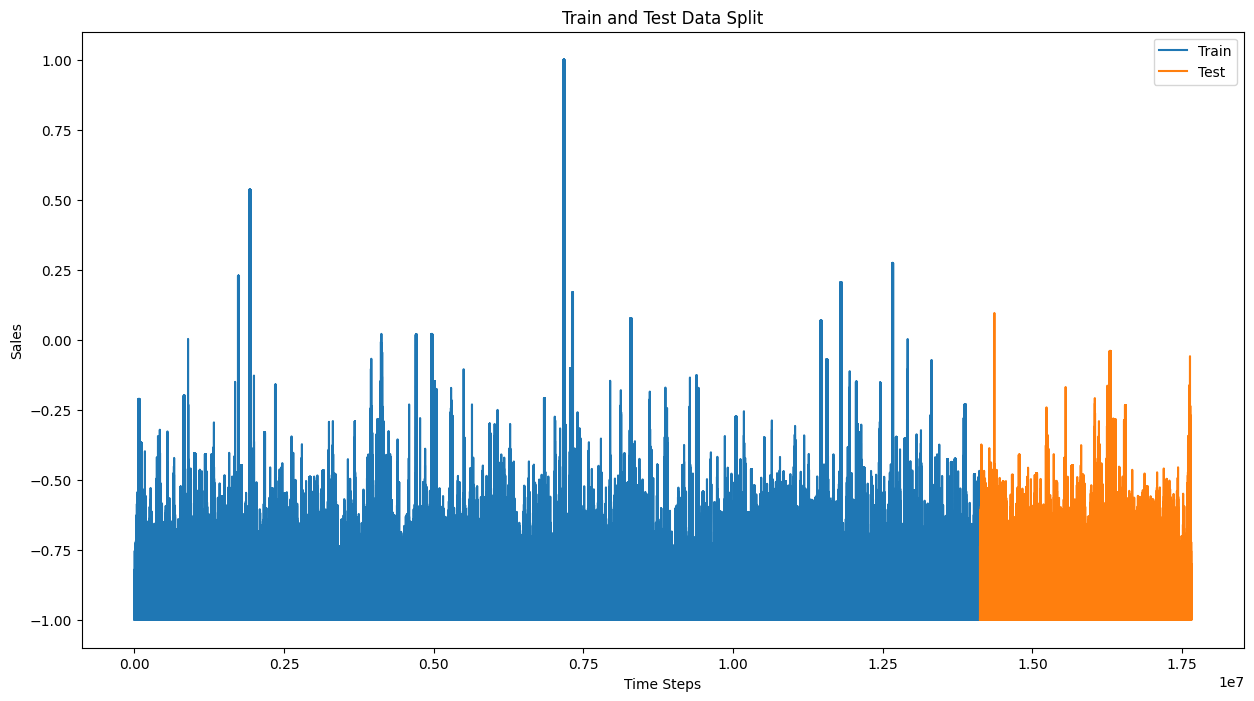

In [104]:
# Create time indices for training and testing data
train_index = np.arange(len(y_train))
test_index = np.arange(len(y_train), len(y_train) + len(y_test))

plt.figure(figsize=(15,8))
plt.plot(train_index, y_train, label='Train')
plt.plot(test_index, y_test, label='Test')
plt.legend(['Train', 'Test'])
plt.title('Train and Test Data Split')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.show()

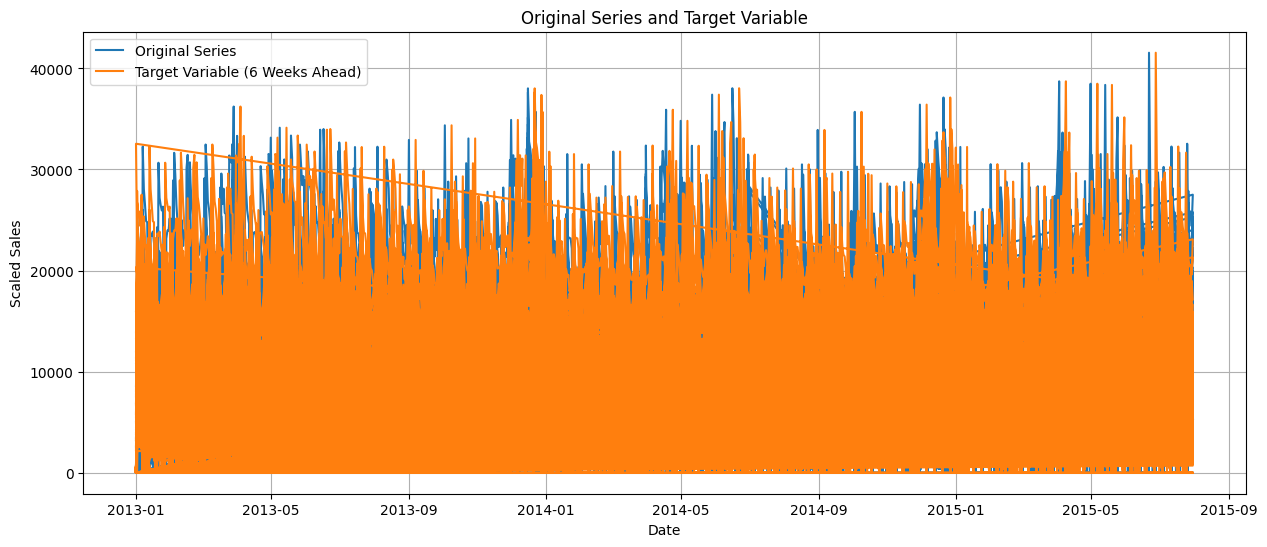

In [139]:
plt.figure(figsize=(15, 6))
plt.plot(df_series.index, df_series['Sales'], label='Original Series')
plt.plot(df_series.index[6:], df_series['Sales'].shift(-6)[6:], label='Target Variable (6 Weeks Ahead)')
plt.xlabel('Date')
plt.ylabel('Scaled Sales')
plt.title('Original Series and Target Variable')
plt.legend()
plt.grid(True)
plt.show()

## Build the LSTM model

In [152]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (813757, 10, 1)
y_train shape: (813757, 1)
X_test shape: (203432, 10, 1)
y_test shape: (203432, 1)


## Model summary

In [153]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit the model

In [155]:

history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
6358/6358 [==============================] - 59s 9ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 2/50
6358/6358 [==============================] - 57s 9ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/50
6358/6358 [==============================] - 57s 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/50
6358/6358 [==============================] - 59s 9ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/50
6358/6358 [==============================] - 58s 9ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/50
6358/6358 [==============================] - 58s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/50
6358/6358 [==============================] - 58s 9ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/50
6358/6358 [==============================] - 60s 9ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/50
6358/6358 [==============================] - 58s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/50
6358/6358 [==============================] - 58s 9ms/step - l

In [156]:
history

In [157]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

6358/6358 [==============================] - 19s 3ms/step - loss: 0.0011
Test Loss: 0.0011050344910472631


## Make predictions on the test set

6358/6358 [==============================] - 17s 3ms/step
Predicted: 4895.50, Actual: 5830.00
Predicted: 4881.25, Actual: 6372.00
Predicted: 5657.23, Actual: 4562.00
Predicted: 6013.32, Actual: 6194.00
Predicted: -77.64, Actual: 0.00
Predicted: 6108.31, Actual: 5890.00
Predicted: 6604.86, Actual: 7625.00
Predicted: 6580.15, Actual: 8010.00
Predicted: 8271.78, Actual: 8756.00
Predicted: 9190.07, Actual: 10011.00


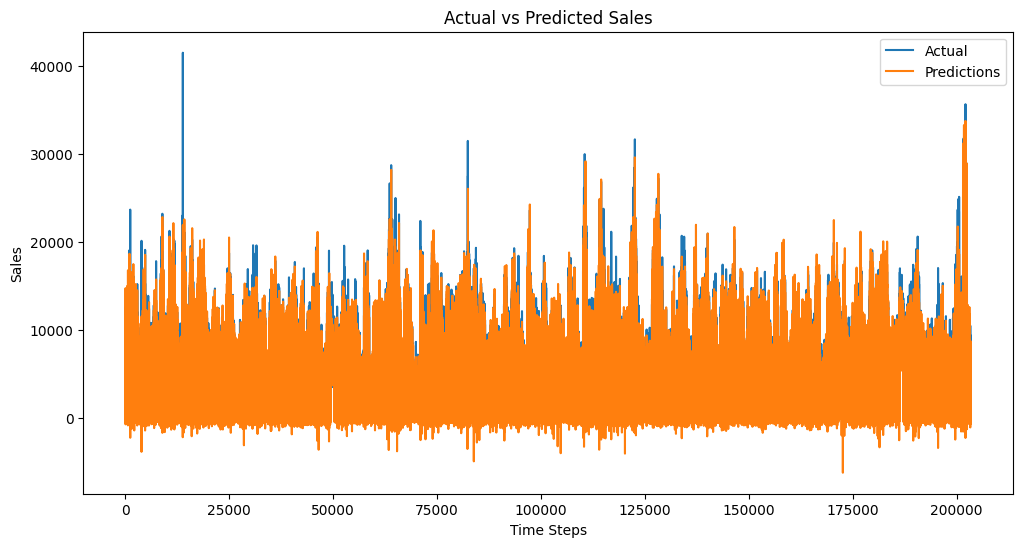

In [159]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform predictions to get original scale
predictions = scaler.inverse_transform(predictions)

# Inverse transform y_test for comparison in original scale
y_test_original = scaler.inverse_transform(y_test)


for i in range(10):
    print(f"Predicted: {predictions[i][0]:.2f}, Actual: {y_test_original[i][0]:.2f}")

# Optionally, visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.show()

## Save the model to a file with timestamp

In [160]:
import   datetime
# Get current timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Save the model with timestamp in the filename
model_filename = f'rossman_forcast_model_{timestamp}.h5'
model.save(model_filename)

print(f"Model saved as: {model_filename}")

Model saved as: rossman_forcast_model_20240603-030903.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# New Section